# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Wednesday, March 15, 2023 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    accuracy_score
    # plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a customer will cancel the reservation they have made at a hotel. 
For this problem, you will use [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). In this data set, there are about 18.000 examples and 18 features (including the target), and the goal is to estimate whether a person will cancel their booking; this column is labeled "booking_status" in the data (1 = canceled). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

<br><br>

### SOLUTION
My initial thoughts on the dataset:
- It looks quite clean. Doesnt seem to require much data cleaning (I will have to verify this during EDA)
- The dataset has a lot of integer columns.

In the code cell below, I read in the data

In [2]:
# OBTAINING TRAIN PATH
DATA_PATH = "data/train__dataset.csv"

# READING THE DATA
data = pd.read_csv(DATA_PATH)

# DISPLAYING A SAMPLE OF THE DATA
data.head()


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0


## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

*** 
**SOLUTION**

In the code cell below, I separated the target variables from the predictors and then split them into training and testing sets.

In [3]:
# SPLITTING INTO PREDICTORS AND TARGETS
X, y = data.drop("booking_status", axis=1), data["booking_status"]

# TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) 

# CHECKING THE DIMENSIONALITIES
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14509, 17), (3628, 17), (14509,), (3628,))

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

***
### Checking For Missing Values 

The function below takes in a pandas dataset and checks if it has empty values. I will use this to check if the test sets and the train sets have null values. If null values are present, I will consider a form of imputation or dropping of the rows.

In [4]:
# Importing Union for type hinting for readability
from typing import Union 

def check_if_null(data: pd.DataFrame) -> Union[bool, None]:
    """
    Returns True if data has missing values
    Args:
        data (pd.DataFrame): Pandas Dataframe 

    Returns:
        Union[bool, None]: True if     
    """

    if data.isnull().sum().sum() != 0: 
        print("DataSet set has missing values")
        return True

    print(f"SUCCESS!!! No Missing Values in the dataset")
    return



Having defined the function, I will use it to check if the Train_set has missing values. The code cell below does that.

In [5]:
# Checking of train and test sets have missing values
check_if_null(X_train)
check_if_null(X_test)

SUCCESS!!! No Missing Values in the dataset
SUCCESS!!! No Missing Values in the dataset


#### Checking for Class Imbalance
Class imbalance might need to be taken into account for us to decide on what metric to use.
The code cell below calculates the class imbalance of the dataset.

0.6724102281342615

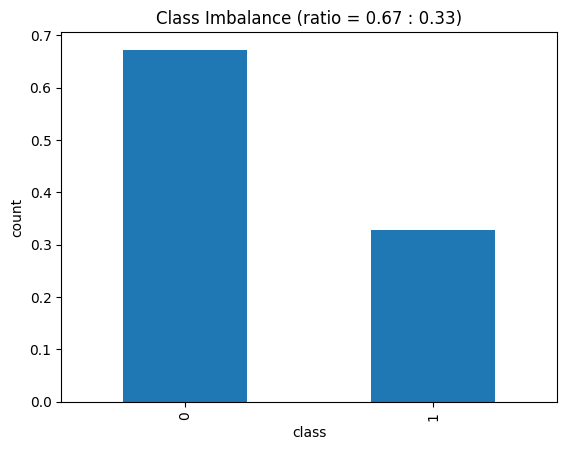

In [6]:
# plt.y_train.value_counts(normalize=True)
proportions = y_train.value_counts(normalize=True)


# plt.bar(proportions)
ratios = f"{proportions[0]:.2f} : {proportions[1]:.2f}"
proportions.plot.bar()
plt.title(f"Class Imbalance (ratio = {ratios})")
plt.xlabel("class")
plt.ylabel("count")
proportions[0]

**Class Imbalance Observations**

As we see above, there is a class imbalance in the dataset. A dumb model which only predicts the most frequent class would be 67% accurate. 

Therefore, I will not use accuracy as the metric. I will use `F-1 SCORE` as the metric.


### Checking the distributions of some columns

In the code cell below, I visually check the distributions of some columns in the dataset. I chose to check the distributions of `lead_time` and `avg_price_per_room` for the following reasons
- I hypothesise that there is an association between amount of time between booking an appointment and arriving for the appointment. This is because, the further away from the booked date, the more chances of many circumstances that might cause a person to cancel.
- If the price per room is high, people might decide to cancel appointments (Money does not grow on trees unfortunately)

The code cell below plots the two visualizations

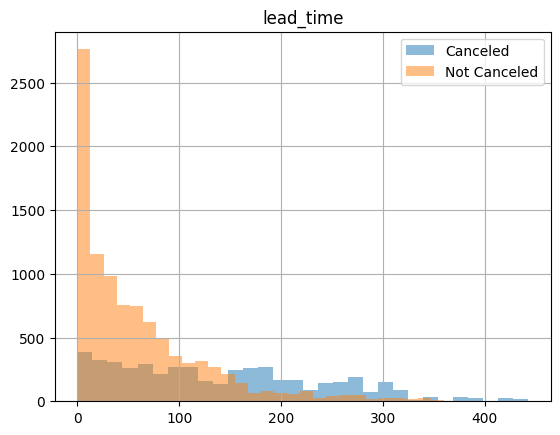

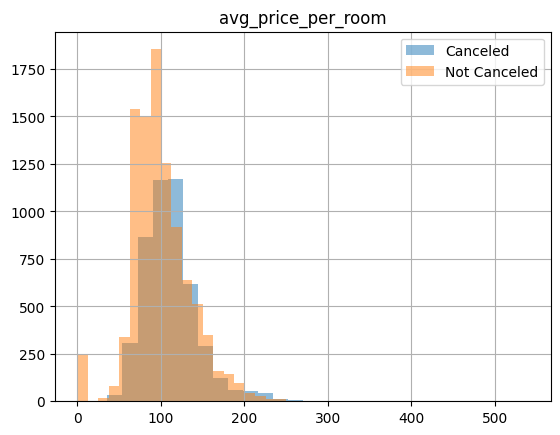

In [7]:
# OBTAINING CANCELLED AND UNCANCELLED MASKS
canceled_mask = [True if i == 1 else False for i in y_train]
non_canceled_mask = [True if i == 0 else False for i in y_train]

# SEPARATING CANCELED AND UNCANCELLED DATA
canceled = X_train[canceled_mask]
non_canceled = X_train[non_canceled_mask]

# PLOTTING
columns = ["lead_time",  "avg_price_per_room",]
for column in columns:
    plt.hist(canceled[column], bins=30, label="Canceled", alpha=0.5)
    plt.hist(non_canceled[column], bins=30, label="Not Canceled",alpha=0.5)
    plt.title(column)
    plt.legend()
    plt.grid()
    plt.show() 
    plt.close()

### **Final Thoughts on the data**

- There is a high class imbalance in the dataset, and the positive class (cancelled) is under-represented. Therefore **F1-score** seems like a more important metric than accuracy
- `arrival_year` and `arrival_date` might not be important features in our model. This is because, when we build the model to predict whether or not a booking is cancelled, the year will likely be different from the ones modeled. 
- `arrival_month` might be a useful feature since some months of the year (such as the holiday seasons) might be highly associated with cancelations of bookings

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

***
#### SOLUTION
I decided to add one more column which I think might add value to the dataset. I decided to add a `cost` column. cost is given by the following formula:
> cost = avg_price_per_room * (no_of_adults+no_of_children)

I decided to add this because I hypothesise that the number of people(who might share the cost) and the cost might have influence on the likelihood of cancelling

In the code cell below, I defined a function that adds the column. I then called the function on the training data

In [8]:
from typing import List

def add_cost(data: pd.DataFrame, cols: List[str]=["avg_price_per_room", "no_of_adults", "no_of_children"]) -> pd.DataFrame:
    """Add new cost column
    The cost coumn is given by : avg_price_per_room * (no_of_adults+no_of_children)

    Args:
        data (pd.DataFrame): The dataframe, either testset or train set
        cols (List[str]): The colummns from which we obtain the new column

    Returns:
        pd.DataFrame: The new dataframe with the assigned column
    """
    new_df = data.assign(
        cost = data[cols[0]]*(data[cols[1]]+data[cols[2]])
    )
    return new_df

# Adding the cost column to the training 
X_train, X_test = add_cost(X_train), add_cost(X_test)
X_train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,cost
11045,1,0,1,0,1,0,0,27,2018,9,25,1,0,0,0,104.0,1,104.0
5031,2,0,1,2,0,0,0,233,2018,10,14,0,0,0,0,90.0,0,180.0
9538,2,0,0,2,0,0,0,59,2017,10,29,0,0,0,0,85.0,0,170.0
10225,1,0,1,3,0,0,0,0,2018,12,29,0,0,0,0,65.0,0,65.0
8721,3,0,1,4,0,0,1,112,2018,8,22,1,0,0,0,150.3,0,450.9


<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

***
#### SOLUTION
Before I do the transformations. I would like to check the ranges of every individual column. If the ranges are too high, i might consider scaling. 

The code cell below prints out the name of the column, the number of unique variables and the range of the values.

In [9]:
for col in X_train.columns:
    print(f"{col}, Unique: {X_train[col].nunique()}, Range: {min(X_train[col]), max(X_train[col])}")

no_of_adults, Unique: 5, Range: (0, 4)
no_of_children, Unique: 5, Range: (0, 9)
no_of_weekend_nights, Unique: 8, Range: (0, 7)
no_of_week_nights, Unique: 18, Range: (0, 17)
type_of_meal_plan, Unique: 4, Range: (0, 3)
required_car_parking_space, Unique: 2, Range: (0, 1)
room_type_reserved, Unique: 7, Range: (0, 6)
lead_time, Unique: 340, Range: (0, 443)
arrival_year, Unique: 2, Range: (2017, 2018)
arrival_month, Unique: 12, Range: (1, 12)
arrival_date, Unique: 31, Range: (1, 31)
market_segment_type, Unique: 5, Range: (0, 4)
repeated_guest, Unique: 2, Range: (0, 1)
no_of_previous_cancellations, Unique: 9, Range: (0, 13)
no_of_previous_bookings_not_canceled, Unique: 43, Range: (0, 58)
avg_price_per_room, Unique: 2393, Range: (0.0, 540.0)
no_of_special_requests, Unique: 6, Range: (0, 5)
cost, Unique: 2952, Range: (0.0, 1331.5)


**OBSERVATIOINS AND DECISIONS**

*Observations*
- All columns are numeric, no strings
- `cost`, `avg_price_per_room` are floats, the rest are integers

*Decisions*
- Scale the costs and the average price columns (since they are continous and in different ranges)  
- Drop the year column (It doesnt seem useful)
- Leave the rest as is (Since they are discrete)

In the code cell below I made a column transformer performing these decisions

In [10]:
# FEATURES TO DROP
drop_features = ["arrival_year"]

# FEATURES TO SCALE
float_numeric_features = ["lead_time", "cost", "avg_price_per_room"]


numeric_pipe = make_column_transformer(
    (StandardScaler(), float_numeric_features),
    ("drop", drop_features),
    remainder="passthrough"
)

# FITTING TRANSFORMER
X_train = numeric_pipe.fit_transform(X_train)
X_test = numeric_pipe.transform(X_test)

# CHECKING SHAPE TO ENSURE THAT IT MAKES SENSE
X_train.shape, y_train.shape

((14509, 17), (14509,))

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

*** 
#### SOLUTION
In the code cell below, I used the DummyClassifier model. I obtained both the accuracy score and the f-1 score. However, the metric that I am interested in is the F1.

In [11]:
baseline = DummyClassifier()
baseline.fit(X_train, y_train)
y_preds = baseline.predict(X_train)

f1_score(y_train, y_preds)
accuracy_score(y_train, y_preds)

summary = {"f1 score": f1_score(y_train, y_preds),
        "accuracy": accuracy_score(y_train, y_preds)}
print(f"f-1 score: {summary['f1 score']}")

f-1 score: 0.0


As we see above, the performance of the model is so bad with an f-1 score of 0. We will need to come up with a better model.

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

***
#### **IMPORTANT NOTE!!**
Before I try the logistic regression, I noticed that, later in this assignment, I would need to perform cross validation using other models of my choice. I decided to write a function that does this in order to reduce the amount of "similar" code for every model. The code cell below shows the function.

In [12]:
from typing import List
def cross_val_train(model: str, params: List[float], metrics: List[str]) -> pd.DataFrame:
    """
    Given the name of the model, this function performs a cross validation on different hyperparameters and returns the means and standard deviations using the metrics specified

    Args:
        model (str): name of classifier to be used. 
        params (List[float]): a list of hyperparamers
        metrics (List[str]): a list of metrics

    Returns:
        pd.DataFrame: A dataframe of scores of the cross validations
    """

    # Make sure the model is one of the models I will use
    assert model in ["Logistic", "SVM", "KNN", "Random Forest"], "Check your spelling"

    # A dictionary to store the standard deviation and the means of the metrics in the model
    results = dict()

    # Performing cross validation for logistic regressiom
    if model == "Logistic":
        for param in params:
            log_reg = LogisticRegression(max_iter=1000, C=param, random_state=42)
            cross_val_results = cross_validate(log_reg, X_train, y_train, 
                            scoring=metrics, return_train_score=True, n_jobs=-1)
            results["C="+str(param)+"_std"]= pd.DataFrame(cross_val_results).std()
            results["C="+str(param)+"_mean"]= pd.DataFrame(cross_val_results).mean()
        return pd.DataFrame(results).T.drop(["fit_time", "score_time"], axis=1)
        
    # Performing crossvalidation for Support vector machines
    elif model == "SVM":
        for param in params:
            svm_clf = SVC(C=param, random_state=42)
            cross_val_results = cross_validate(svm_clf, X_train, y_train, 
                        scoring=metrics, return_train_score=True, n_jobs=-1)
            results["C="+str(param)+"_std"]= pd.DataFrame(cross_val_results).std()
            results["C="+str(param)+"_mean"]= pd.DataFrame(cross_val_results).mean()
        return pd.DataFrame(results).T.drop(["fit_time", "score_time"], axis=1)
    
    # Performing crossvalidation for Random forest
    elif model == "Random Forest":
        for param in params:
            clf_rf = RandomForestClassifier(max_depth=param, random_state=42)
            cross_val_results = cross_validate(clf_rf, X_train, y_train, 
                        scoring=metrics, return_train_score=True, n_jobs=-1)
            results["max_depth="+str(param)+"_std"]= pd.DataFrame(cross_val_results).std()
            results["max_depth="+str(param)+"_mean"]= pd.DataFrame(cross_val_results).mean()
        return pd.DataFrame(results).T.drop(["fit_time", "score_time"], axis=1)

    # Performing cv for knn
    else:
        for param in params:
            knn_clf = KNeighborsClassifier(n_neighbors=param)
            cross_val_results = cross_validate(knn_clf, X_train, y_train, 
                            scoring=metrics, return_train_score=True, n_jobs=-1)
            results["k="+str(param)+"_std"]= pd.DataFrame(cross_val_results).std()
            results["k="+str(param)+"_mean"]= pd.DataFrame(cross_val_results).mean()
        return pd.DataFrame(results).T.drop(["fit_time", "score_time"], axis=1)

Having Implemented the function, Now I will first run the logistic regression model.

- The code cell below runs the cross_validation with different values of the C hyperparameter.

In [13]:
metrics = ["f1", "accuracy"]
logistic_par = [0.01, 0.1, 1, 10, 100]
log_cv = cross_val_train("Logistic",logistic_par,metrics)
log_cv

,test_f1,train_f1,test_accuracy,train_accuracy
C=0.01_std,0.009068,0.002283,0.004902,0.001048
C=0.01_mean,0.626834,0.627765,0.787718,0.788183
C=0.1_std,0.007359,0.002510,0.003950,0.001190
C=0.1_mean,0.643352,0.644439,0.791095,0.791043
C=1_std,0.006209,0.002755,0.003115,0.001252
C=1_mean,0.649380,0.649410,0.792887,0.792715
C=10_std,0.006277,0.002974,0.003053,0.001377
C=10_mean,0.649869,0.650166,0.792887,0.792939
C=100_std,0.006294,0.002949,0.003048,0.001383
C=100_mean,0.649635,0.650304,0.792749,0.792991


**OBSERVATIONS ON LOGISTIC REGRESSION**

- From the model above, we see that, on average, the value of C that is giving us the best f-1 score is C=100.
- The standard deviation is not to large, which implies that the model can be trusted
- In the code cell below, I instantiated the logistic regression model and set the hyperparameter C=100 to see how it performs on the test set

In [14]:
lr = LogisticRegression(max_iter=1000, C=100, random_state=42)
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_train)
lr_summary = {
    "f1_score": f1_score(y_train, y_preds_lr),
    "accuracy": accuracy_score(y_train, y_preds_lr)
    }
print(f"f-1 score: {lr_summary['f1_score']}")

f-1 score: 0.6494593651900942


<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

***
#### **SOLUTION**

I decided to use the following classifiers:
- Random Forest
- K nearest Neighbours
- Support Vector Machines



##### **Random Forest**

In [15]:
# RANDOM FOREST CLASSIFIER
depths = [5, 10, 15, 20]
rf_cv = cross_val_train("Random Forest", params=depths, metrics=metrics)
rf_cv

,test_f1,train_f1,test_accuracy,train_accuracy
max_depth=5_std,0.014174,0.018304,0.005472,0.006328
max_depth=5_mean,0.660600,0.669705,0.821146,0.825556
max_depth=10_std,0.008291,0.001972,0.003923,0.000943
max_depth=10_mean,0.785503,0.822851,0.872700,0.893480
max_depth=15_std,0.005755,0.004848,0.002796,0.002929
max_depth=15_mean,0.813440,0.919291,0.885106,0.948877
max_depth=20_std,0.002391,0.002018,0.001530,0.001284
max_depth=20_mean,0.819404,0.982802,0.888414,0.988817


**OBSERVATIONS ON RANDOM FOREST**

- Random forest is giving us much better results. The best seen f-1 score (of 0.819) is seen at max_depth=20. Its standard deviation is also low which means we can trust it. The downside of this model is that it seems to overfit 

***
##### **K NEAREST NEIGHBOUR**

In [16]:
n_neighbours = [2,5,10,15]
knn_cv = cross_val_train("KNN", params=n_neighbours, metrics=metrics)
knn_cv


,test_f1,train_f1,test_accuracy,train_accuracy
k=2_std,0.012989,0.003763,0.005579,0.001808
k=2_mean,0.659712,0.823564,0.813357,0.901475
k=5_std,0.010211,0.002223,0.007338,0.001261
k=5_mean,0.689326,0.799843,0.806947,0.875146
k=10_std,0.007500,0.004896,0.005407,0.002549
k=10_mean,0.647926,0.717080,0.803432,0.840668
k=15_std,0.011060,0.001953,0.007663,0.001728
k=15_mean,0.649566,0.708168,0.797987,0.830674


**OBSERVATIONS ON KNN**

- While knn is performing better than the baseline model, it is greatly outperformed by the random forest classifier. 
- This bad performance is not surprising since knn is not known to perform good in high dimensional datasets.

***
##### **SUPPORT VECTOR MACHINES**

In [17]:
svm_pars = [0.1, 1, 10]
svm_cv = cross_val_train("SVM",params=svm_pars,metrics=metrics)
svm_cv

,test_f1,train_f1,test_accuracy,train_accuracy
C=0.1_std,0.014685,0.001635,0.004175,0.000477
C=0.1_mean,0.465280,0.465677,0.756013,0.755876
C=1_std,0.008024,0.003361,0.004786,0.001429
C=1_mean,0.627416,0.630421,0.792404,0.794042
C=10_std,0.006387,0.001890,0.003399,0.001666
C=10_mean,0.669110,0.676110,0.808119,0.812013


**OBSERVATIONS ON SVM**

- Just as KNN, SVM failed to outperform Random forest. However, SVM is not overfitting as much as the other models.


### FINAL SUMMARY ON DIFFERENT CLASSIFIERS!
- Random forest beat logistic regression on performance.
**RANDOM FOREST WON!!**

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

#### SOLUTION
Since random forest gave me the best validation f1 score, I will use it here. 
In the code cell below, I perform a grid search cross validation using a randomforest classifier.

The parameters I chose to tune are the max_depth and the max_features


In [18]:
# SETTING PARAMETER GRID
param_grid = {'max_depth': [18, 20, 30, 40], 
            'max_features': ['sqrt', 'log2', 5, 10]} 

# INITIALIZING THE GRID SEARCH
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, 
                        scoring="f1", n_jobs=-1)

# FITTING GRID SEARCH ON TRAIN SETS
grid_search.fit(X_train, y_train)

# OBTAINING THE BEST SCORE
grid_search_score = grid_search.best_score_
print(f"Best GridSearch Score: {grid_search_score:.3f}")

Best GridSearch Score: 0.822


**OBSERVATIONS**

As we see above, the best model gave us an f-score of 0.822 which is really good, especially when compared to the baseline model which gave us a pathetic f-1 score of 0. 
***

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

#### SOLUTION
There are several methods to check for important features. I will use the feature_importance_ attribute of the random forest classifier to obtain the feature importances. 

This attribute calculates feature importance based on impurity(which is what determines how trees split in a random forest model).

In the code cell below, I display the colums alongside their levels of importance in the model. The rows are sorted from the most important features to the least important


In [19]:
importances = dict()
added = 0
for column, importance in zip(add_cost(data.drop(["arrival_year", "booking_status"], axis=1)).columns, grid_search.best_estimator_.feature_importances_):
    importances[column]= [importance]
importances = pd.DataFrame(importances).T.rename(columns={0:"Importance"}).sort_values(by="Importance", ascending=False)
importances


,Importance
no_of_adults,0.345845
no_of_weekend_nights,0.124086
no_of_children,0.110657
cost,0.091310
no_of_previous_cancellations,0.069912
market_segment_type,0.069034
repeated_guest,0.067387
room_type_reserved,0.042455
required_car_parking_space,0.032207
lead_time,0.013294


<br><br>

To better picture these importances, below is a plot of the importances of the columns in the random forest model.

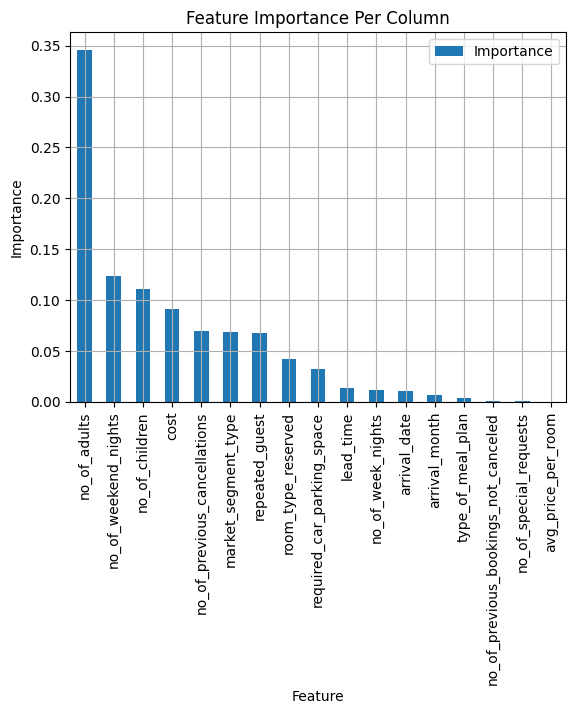

In [20]:
importances.plot(kind="bar") 
plt.title("Feature Importance Per Column")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.grid();


**OBSERVATIONS ON FEATURE IMPORTANCE**
- Number of adults is the most important feature in predicting whether or not a booking is cancelled
- Cost, the column that we added, ended up being more important than the average price per room to our model.

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

In [21]:
grid_score = grid_search.score(X_test, y_test)
print(f"Score On Test Data: {grid_score:.2f}")

Score On Test Data: 0.81


**OBSERVATION ON BEST MODEL**
- The score on test data is 0.81. This matches our validation scores. From our validations scores, we saw that on average, the best score was 0.891 which makes sence.


<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

***
##### SOLUTION

- My final score was an f-1 score of 0.81. This was better than the other models and significantly better than the baseline model
- Other methods that could be important are:
   - Trying boosting methods such as XGBOOST and adaboost
   - Trying a neural network. The downside of this is that it is not easy to interpret.
   - Trying more hyper-parameters, such as more C values on SVM
   - Combatting class imbalance with methods such as oversampling

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 